In [1]:
import torch
from torch import nn
from tqdm import tqdm
import toml
os.chdir("..")

/home/elhanzo/.local/miniconda3/envs/iic/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [244]:
from torchvision import models
model = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/elhanzo/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:06<00:00, 26.1MB/s] 


In [245]:
from core.dl_framework.utils import read_config
from core.dl_framework.data import data_pipeline
from core.dl_framework.learner import Learner
from pathlib import Path
import numpy as np
from torchvision import transforms
config_file = read_config(toml.load("configs/default_train_config.toml"))
config_file = read_config(toml.load("configs/default_train_config.toml"))
train_data_path = "seg_train/seg_train"
data = data_pipeline(config_file, train_data_path, "train_data", False)
learn = Learner(data, config_file, model)
# data_norm = next(iter(data.train_dl))



In [246]:
learn.fit(20)

100%|██████████| 44/44 [00:06<00:00,  6.77it/s]


epoch: 1/20	[valid_acc: 0.9224	valid_acc_per_class: [0.9083 0.9848 0.8837 0.868  0.9634 0.9306]	valid_loss: 85.4058	train_loss: 88.5198	train_time: 00:01:19]
best checkpoint: valid_loss: 85.40582604841752


100%|██████████| 44/44 [00:06<00:00,  6.80it/s]


epoch: 2/20	[valid_acc: 0.9341	valid_acc_per_class: [0.9307 0.9873 0.9059 0.887  0.9631 0.9371]	valid_loss: 80.0291	train_loss: 82.6784	train_time: 00:02:54]
best checkpoint: valid_loss: 80.02906851335005


100%|██████████| 44/44 [00:06<00:00,  6.69it/s]


epoch: 3/20	[valid_acc: 0.9306	valid_acc_per_class: [0.9231 0.9873 0.9081 0.8708 0.9624 0.9367]	valid_loss: 74.7831	train_loss: 77.2823	train_time: 00:04:29]
best checkpoint: valid_loss: 74.78313515403055


100%|██████████| 44/44 [00:06<00:00,  6.81it/s]


epoch: 4/20	[valid_acc: 0.9292	valid_acc_per_class: [0.9269 0.9873 0.9084 0.8559 0.9609 0.9468]	valid_loss: 69.6532	train_loss: 72.0276	train_time: 00:06:04]
best checkpoint: valid_loss: 69.65316720442338


100%|██████████| 44/44 [00:06<00:00,  6.71it/s]


epoch: 5/20	[valid_acc: 0.9310	valid_acc_per_class: [0.9201 0.989  0.909  0.8667 0.9624 0.9455]	valid_loss: 64.7069	train_loss: 66.9468	train_time: 00:07:38]
best checkpoint: valid_loss: 64.70687033913352


  3%|▎         | 5/175 [00:02<01:38,  1.72it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/elhanzo/.local/miniconda3/envs/iic/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_5380/2601539246.py", line 1, in <cell line: 1>
    learn.fit(20)
  File "/mnt/f/Insync/Marcel_Moczarski/Data_Science/Projects/intel-image-classification/core/dl_framework/learner.py", line 57, in fit
    self.all_batches(self.learn.data.train_dl)
  File "/mnt/f/Insync/Marcel_Moczarski/Data_Science/Projects/intel-image-classification/core/dl_framework/learner.py", line 69, in all_batches
    self.cbh.on_batch_end()
  File "/mnt/f/Insync/Marcel_Moczarski/Data_Science/Projects/intel-image-classification/core/dl_framework/callbacks.py", line 95, in on_batch_end
    cb.on_batch_end()
  File "/mnt/f/Insync/Marcel_Moczarski/Data_Science/Projects/intel-image-classification/core/dl_framework/callbacks.py", line 204, in on_batch_end
    batch_correct 

In [25]:
from core.dl_framework.data import CustomDataset
from core.dl_framework.data import get_transforms
data_path = (Path(config_file["p_local_data_path"]) / "processed_files" / "train_data" ).with_suffix(".h5")
transform = get_transforms(config_file)
dataset = CustomDataset(data_path, transform)

In [183]:
from core.dl_framework.utils import get_specific_history
from core.dl_framework.utils import plot_history_all
best_history = get_specific_history(Path(config_file["c_c_ckp_path"]), monitor="valid_acc", browse_all_files=True)
best_model_dict = torch.load(best_history[-1])
learn.learn.model.load_state_dict(best_model_dict["state_dict"])
learn.learn.opt.load_state_dict(best_model_dict["optimizer"])

In [208]:
from torch.utils.data import DataLoader
def get_mean_and_std(dataloader):
    pbar_dl = tqdm(dataloader, total=len(dataloader))
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for i, (xb, yb) in enumerate(pbar_dl):
        channels_sum += torch.mean(xb, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(xb**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

# DataLoader(len(data.train_dl.dataset), batch_size=64)
# channels_sum, channels_squared_sum, num_batches = 0, 0, 0
# pbar_ds = tqdm(data.train_dl.dataset, total=len(data.train_dl.dataset))

# for xs, ys in pbar_ds:
#     channels_sum += torch.mean(xb, dim=[0, 2, 3])
#     channels_squared_sum += torch.mean(xb**2, dim=[0, 2, 3])
#     num_batches += 1

# mean = channels_sum / num_batches
# std = (channels_squared_sum / num_batches - mean**2)**0.5

100%|██████████| 14034/14034 [00:42<00:00, 329.55it/s]


In [123]:
def test_arch(learn, model):
    valid_dl = learn.learn.data.valid_dl
    device = learn.device
    model = model.to(device)
    criterion = learn.learn.loss_func
    model.eval()
    with torch.no_grad():
        correct = 0
        pbar_valid_dl = tqdm(valid_dl, total=len(valid_dl))
        for xb, yb, idx in pbar_valid_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            _, pred = torch.max(out.data, 1)
            correct += (pred == yb).sum().item() / len(yb)
            loss = criterion.calc(out, yb)
        print(correct/len(valid_dl))
        

test_arch(learn, learn.learn.model)


100%|██████████| 44/44 [00:01<00:00, 25.81it/s]

0.7915030991735538


In [237]:
from PIL import Image
from core.dl_framework.data import get_transforms

test_img = Image.open("test_img.jpg")
t = get_transforms(config_file)
transform = transforms.Compose([t[0], transforms.ToTensor(), t[-1]])
img = transform(test_img).unsqueeze(0)
out = learn.learn.model(img.to(learn.device))
torch.max(out.data, 1)[1].item()
# transforms.ToPILImage()(img.squeeze())


2

In [200]:
test = img
channels_sum, channels_squared_sum, num_batches = 0, 0, 0

channels_sum += torch.mean(test, dim=[0, 2, 3])
channels_squared_sum += torch.mean(test**2, dim=[0, 2, 3])
num_batches += 1

mean = channels_sum / num_batches
std = (channels_squared_sum / num_batches - mean**2)**0.5
mean, std

(tensor([0.6023, 0.6521, 0.5619]), tensor([0.3451, 0.2762, 0.2727]))

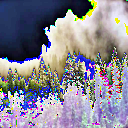

In [213]:
img = transforms.Normalize([0.6023, 0.6521, 0.5619], [0.3451, 0.2762, 0.2727])(img)
transforms.ToPILImage()(img.squeeze())


In [5]:
plot_history_all(best_history)
# best_history[0][0]

In [43]:
import torchvision
pretrained = True
batch = next(iter(data.train_dl))
img = batch[0].permute(0, 3, 2, 1)
model = torchvision.models.resnet18(pretrained)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

model(img/255)
# import matplotlib.pyplot as plt
# plt.imshow(img.permute(0, 1, 2))


tensor([[ 2.9437e-02,  5.6660e-01,  4.3710e-01, -2.4919e-01,  5.2946e-01,
          1.5116e+00],
        [-2.1430e-01, -6.8146e-01, -3.8934e-01, -4.1285e-01,  4.3214e-02,
          9.3181e-01],
        [ 2.8854e-01, -2.7958e-01, -2.1406e-01, -1.4422e+00,  1.7665e-02,
          1.0402e+00],
        [ 7.6974e-01, -1.1695e-02,  4.0755e-01, -1.0151e+00, -2.5027e-01,
          7.6901e-01],
        [-9.4725e-02,  1.0334e+00,  1.7287e+00, -1.1007e+00,  1.6617e-01,
          8.1947e-01],
        [ 1.2263e-01, -2.3190e-01,  2.1097e-01, -4.7100e-01,  6.9263e-01,
          7.1590e-01],
        [ 1.3604e-01,  1.0653e-01,  7.0132e-01,  1.3013e+00, -2.6025e-01,
          4.0852e-01],
        [-5.1715e-01,  2.5876e-01,  3.2860e-01, -4.8839e-01, -5.5886e-01,
          6.0666e-01],
        [-1.3317e-01, -1.9250e-01,  6.1959e-01, -1.0243e+00,  1.5129e-01,
          6.5095e-01],
        [-9.0879e-02, -3.3638e-02, -4.4355e-01, -1.9576e-01, -4.7457e-01,
          6.9916e-01],
        [-3.6090e-01, -1.4958e

In [8]:
import h5py
from pathlib import Path
data_path = Path(config_file["p_local_data_path"]) / "processed_files" / "train_data.h5"
dset = h5py.File(data_path, "r") 

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [133]:

    
img = next(iter(data_test.train_dl))[0]
# net = CustomModel(img.size(1), 6, 16, 124, 4)
# img.size(2)
data_test.train_dl.dataset[0][0].shape
learn.learn.model(img)


tensor([[-2.9168e-01],
        [-1.6196e-01],
        [ 2.9472e-01],
        [ 6.2239e-02],
        [ 1.9767e-01],
        [-4.6405e-01],
        [-8.1470e-01],
        [-2.6797e-01],
        [-3.7364e-01],
        [ 1.8129e-01],
        [ 8.5726e-02],
        [ 5.2427e-01],
        [ 5.0081e-02],
        [-6.7159e-01],
        [ 2.2814e-01],
        [-8.1703e-02],
        [-1.9749e-01],
        [ 3.3920e-02],
        [ 2.7294e-01],
        [ 6.6710e-04],
        [ 9.9744e-02],
        [-5.0846e-01],
        [-1.0967e-01],
        [-1.8858e-02],
        [ 8.7219e-01],
        [ 2.1678e-01],
        [ 3.8744e-01],
        [ 1.8138e-01],
        [-1.9797e-02],
        [ 7.9672e-01],
        [ 2.2826e-01],
        [ 1.5312e-01],
        [ 1.1312e-01],
        [-1.7619e-01],
        [ 2.5308e-02],
        [-3.1693e-01],
        [ 3.3003e-01],
        [-5.1250e-01],
        [-1.9844e-02],
        [-6.8867e-01],
        [-8.9160e-01],
        [-3.8979e-01],
        [ 3.8396e-01],
        [ 2

In [114]:
img = next(iter(data_test.train_dl))[0]
img.shape

torch.Size([64, 3, 124, 124])

In [126]:
def conv_output_size(w, k=3, p=2, s=1):
    return ((w - k + 2*p) / s + 1)
conv_output_size(124,3,1,1)
conv_output_size(124, 2, 0, 2)
62*62*16
# conv_output_size(1984, 1, 2)

61504